### Определение перспективного тарифа для телеком-компании
------------------


ШАГ 1: Импорт данных
----------

In [1]:
# импортируем необходимые библиотеки
# и ознакомимся с данными 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', None)

# Создадим датафреймы из имеющихся таблиц
calls = pd.read_csv('/datasets/calls.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')



----------
ШАГ 2: Подготовка данных
----------

#### Звонки

In [2]:
# Согласно условию в данных много звонков длительностью 0.0 минут, посмотрим сколько
calls.query('duration == 0.0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [3]:
(calls.query('duration == 0.0').shape[0]/calls.shape[0])

0.19551644316336553

Нулевых звонков почти `20 %` от всего количества, это очень много, удалить такое количество нельзя    
Можно заменить на `1`, так как в условиях указано что оператор всегда округляет звонки "вверх".

In [4]:
# Звонки
# Приводим к datetime формату, извлекаем месяцы в отдельную колонку
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month

# Согласно условию каждый звонок имеет какую-то длительность
# Поэтому заменяем "нулевые" звонки на минутные  
# Округляем все звонки "вверх". 

calls.loc[calls['duration'] == 0.0, 'duration'] = 1.0 
calls['duration']=calls['duration'].apply(np.ceil).astype('int')

In [5]:
# делаем сводную таблицу с группировкой по "user_id" и "month"
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values=['duration'],  aggfunc=['sum', 'count'])

# Переименуем названия столбцов  
calls_pivot.columns = ['calls_duration', 'calls_count']

# смотрим что получилось
calls_pivot.head()

calls_duration  calls_count
user_id month                             
1000    5                 164           22
        6                 187           43
        7                 346           47
        8                 418           52
        9                 478           58

#### Интернет

In [6]:
# Интернет
# тоже самое проделываем с данными по интернет-трафику
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

# Округлим мегабайты "вверх"
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

In [7]:
# Сводная таблица по аналогии с данными по звонкам
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values=['mb_used'],  aggfunc=['sum'])
# изменяем имя колонки
internet_pivot.columns=['mb_used']
# Смотрим на сводную таблицу
internet_pivot.head()

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581

#### Сообщения

In [8]:
# Проводим аналогичные операции (см.выше)
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
# Нужен столбец с днями, чтобы по нему считать количество сообщений в месяце
messages['day'] = messages['message_date'].dt.day
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values=['day'],  aggfunc=['count'])
# изменяем имя колонки
messages_pivot.columns=['message_count']
# Смотрим на сводную таблицу
messages_pivot.head()


message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57

In [9]:
# проверим, если ли пропуски в данных столбца с пользователями
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [10]:
# Есть пропуски в столбце с датой прекращения действия тарифа

In [11]:
# установим индексом столбец "user_id" в таблице с пользователями 
users.set_index('user_id', inplace=True)
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
# создадим список который присоединим к таблице со звонками
data_total = [internet_pivot, messages_pivot]

total = calls_pivot.join(data_total,how='outer')
# теперь к таблице "users" добавляем таблицу "total"
df = users.join(total, how='outer')
df.reset_index(inplace=True)
# Удалим столбцы с возрастом, именем и фамилией, они не нужны в этом ииследовании
df.drop(['age', 'first_name', 'last_name'], axis='columns', inplace=True)
df.head()

,user_id,month,churn_date,city,reg_date,tariff,calls_duration,calls_count,mb_used,message_count
0,1000,5,NaN,Краснодар,2018-05-25,ultra,164.0,22.0,2256.0,22.0
1,1000,6,NaN,Краснодар,2018-05-25,ultra,187.0,43.0,23257.0,60.0
2,1000,7,NaN,Краснодар,2018-05-25,ultra,346.0,47.0,14016.0,75.0
3,1000,8,NaN,Краснодар,2018-05-25,ultra,418.0,52.0,14070.0,81.0
4,1000,9,NaN,Краснодар,2018-05-25,ultra,478.0,58.0,14581.0,57.0


In [13]:
df.shape

(3214, 10)

In [14]:
df.duplicated().sum()

0

In [15]:
# Посмотрим на таблицу с тарифами
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
# создадим столбец с тарифами и удалим исходный столбец
tariffs['tariff']=tariffs['tariff_name']
tariffs.drop('tariff_name', axis='columns', inplace=True)
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [17]:
# Изменим имя колонок, так как "mg" не "mb" в "mg_per_month_included"
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [18]:
# Присоединим таблицу с тарифами к датафрейму 'df'
df = df.merge(tariffs, on='tariff', how='outer')
df.head()

,user_id,month,churn_date,city,reg_date,tariff,calls_duration,calls_count,mb_used,message_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,NaN,Краснодар,2018-05-25,ultra,164.0,22.0,2256.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,6,NaN,Краснодар,2018-05-25,ultra,187.0,43.0,23257.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,7,NaN,Краснодар,2018-05-25,ultra,346.0,47.0,14016.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,8,NaN,Краснодар,2018-05-25,ultra,418.0,52.0,14070.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,9,NaN,Краснодар,2018-05-25,ultra,478.0,58.0,14581.0,57.0,1000,30720,3000,1950,150,1,1


In [19]:
# Согласно условиям, если в "churn_date" нет значений,
# значит что пользователь еще был подключен к тарифу на момент выгрузки данных
# дата выгрузки неизвестна, поэтому зададим ее 31 декабря 2018 г.
# и переведем в формат datetime данные в столбцах 'churn_date' и 'reg_date'
df['churn_date'].fillna('2018-12-31', inplace=True)
df['churn_date'] = pd.to_datetime(df['churn_date'], format='%Y-%m-%d')
df['reg_date'] = pd.to_datetime(df['reg_date'], format='%Y-%m-%d')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
churn_date               3214 non-null datetime64[ns]
city                     3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
calls_duration           3174 non-null float64
calls_count              3174 non-null float64
mb_used                  3203 non-null float64
message_count            2717 non-null float64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(9), object(2)
memory usage: 452.0+ KB


#### Стобцы с продолжительность звонков, сообщениями и Гб содержат пропуски  
------------
Возможные причины:

------------
* Пользователь звонит и пишет через мессенджеры - основной расход это интернет
* Пользователь не пользуется интернетом, а только звонит или пишет смс - Гб не используются 
* Пользователь не пишет смс - мессенджер удобнее
------------
Поэтому будем считать, что если пропуск, то расхода (минуты, сообщения, Гб) не происходит, значит можно заменить на 1,  
это не сильно повлияет на медиану и среднее, не добавит доплаты сверх тарифа, и позволит сохранить данные.

In [20]:
df = df.fillna(1)
df.isna().sum()

user_id                  0
month                    0
churn_date               0
city                     0
reg_date                 0
tariff                   0
calls_duration           0
calls_count              0
mb_used                  0
message_count            0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

In [21]:
#  Также приведем к целочисленному типу "int" столбцы имеющие тип "float"
columns = ['calls_duration','calls_count', 'mb_used', 'message_count']
for column in columns:
    df[column] = df[column].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
churn_date               3214 non-null datetime64[ns]
city                     3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
calls_duration           3214 non-null int64
calls_count              3214 non-null int64
mb_used                  3214 non-null int64
message_count            3214 non-null int64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: datetime64[ns](2), int64(13), object(2)
memory usage: 452.0+ KB


In [22]:
# Рассчитаем выручку по тарифам

# Расчет перерасхода по минутам, если перерасхода нет, то возвращается "0"
def money_per_minutes(row):
    calls_duration=row['calls_duration']
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    minutes = (calls_duration - minutes_included)*rub_per_minute
    if minutes <= 0:
        return 0
    return minutes

df['minutes_money'] = df.apply(money_per_minutes, axis=1)

# Аналогично для сообщений
def money_per_message(row):
    message_count = row['message_count']
    messages_included = row['messages_included']
    rub_per_message = row['rub_per_message']
    message = (message_count - messages_included)*rub_per_message
    if message <=0:
        return 0
    return message

df['messages_money'] = df.apply(money_per_message, axis=1)

# Для интернета
def money_per_gb(row):
    mb_used = row['mb_used']
    mb_per_month_included = row['mb_per_month_included']
    rub_per_gb = row['rub_per_gb']
    gb = (((mb_used - mb_per_month_included)//1024))*rub_per_gb
    if gb <=0:
        return 0
    return gb

df['internet_money'] = df.apply(money_per_gb, axis=1)

# Расчет перерасхода
df['over_fee'] = df['minutes_money'] + df['messages_money'] + df['internet_money']
# Полная сумма
df['total_fee'] = df['over_fee'] + df['rub_monthly_fee']


'\nФункции "костыльные", мне самому не нравятся, но работают\n'


----------
ШАГ 3: Анализ данных
----------

* Опишите поведение клиентов оператора, исходя из выборки.  
* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
* Посчитайте среднее количество, дисперсию и стандартное отклонение.  
* Постройте гистограммы.  
* Опишите распределения.  

#### Предварительная оценка использования тарифов

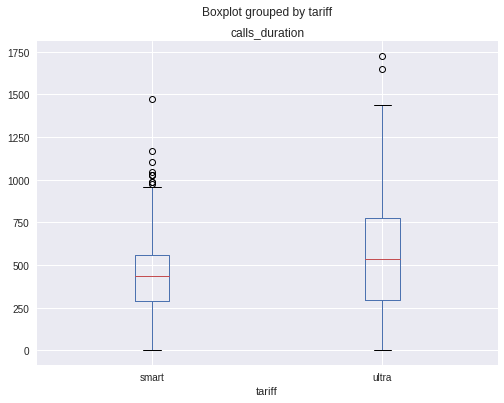

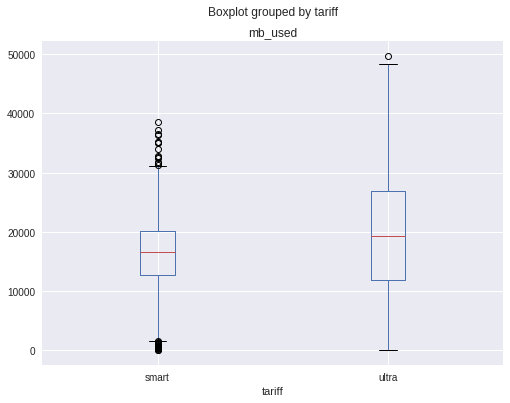

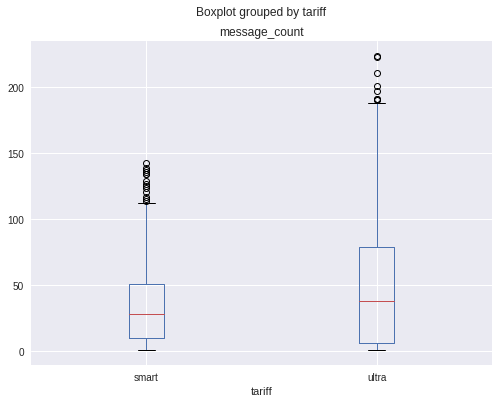

In [23]:
# построим боксплоты для оценки использования пакета тарифов
data_initial = ['calls_duration', 'mb_used', 'message_count']
for column in data_initial:
    df.boxplot(by='tariff', column=column, figsize=(8,6))
    plt.show()


#### Предварительный вывод по расходам пакета
--------
* Медианные значения использования минут, интернета и сообщений для обоих тарифов близки
* Данные обоих тарифов содержат выбросы
* Для тарифа "УЛЬТРА" разброс значений выше
 
* **Удалим выбросы**

##### Для тарифа "СМАРТ"

In [24]:
df_smart = df.query('tariff=="smart"')

In [25]:
# Функция рассчитывает границы "усов" и выводит "0" 
# если нижний значение нижнего "ус"  отрицательное
# либо возвращает его собственное значение, если оно положительное
def iqr_func(df, column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    down = q1 - 1.5*iqr
    if down <= 0:
        print ('Замена на 1:', 1)
    else:
        print ('Нижний ус:', down)
    up = q3 + 1.5*iqr
    print('Верхний ус:', up)

print('Звонки smart')
borders_calls_duration_smart = iqr_func(df_smart,'calls_duration')
print()
print('Интернет smart')
borders_mb_used_smart = iqr_func(df_smart,'mb_used')
print()
print('Сообщения smart')
borders_message_used_smart = iqr_func(df_smart,'message_count')


Звонки smart
Замена на 1: 1
Верхний ус: 963.5

Интернет smart
Нижний ус: 1543.0
Верхний ус: 31183.0

Сообщения smart
Замена на 1: 1
Верхний ус: 112.5


In [26]:
# Удалим строки у которых есть данные за пределами "усов" по звонкам, сообщениям и мегабайтам
df_smart.drop(df_smart.query('calls_duration < 1 or calls_duration > 964').index, inplace=True)
df_smart.drop(df_smart.query('mb_used < 1543 or mb_used > 31183').index, inplace=True)
df_smart.drop(df_smart.query('message_count < 1 or message_count > 113').index, inplace=True)

print('Количество удаленных строк из тарифа "СМАРТ":', df.query('tariff=="smart"').shape[0] - df_smart.shape[0])

Количество удаленных строк из тарифа "СМАРТ": 59


##### Для тарифа "УЛЬТРА"

In [27]:
df_ultra = df.query('tariff=="ultra"')

In [28]:
def iqr_func(df, column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    down = q1 - 1.5*iqr
    if down <= 0:
        print ('Замена на 1:', 1)
    else:
        print ('Нижний ус:', down)
    up = q3 + 1.5*iqr
    print('Верхний ус:', up)

print('Звонки ultra')
borders_calls_duration_ultra = iqr_func(df_ultra,'calls_duration')
print()
print('Интернет ultra')
borders_mb_used_ultra = iqr_func(df_ultra,'mb_used')
print()
print('Сообщения ultra')
borders_message_used_ultra = iqr_func(df_ultra,'message_count')

Звонки ultra
Замена на 1: 1
Верхний ус: 1494.5

Интернет ultra
Замена на 1: 1
Верхний ус: 49480.0

Сообщения ultra
Замена на 1: 1
Верхний ус: 188.5


In [29]:
df_ultra.drop(df_ultra.query('calls_duration < 1 or calls_duration >= 1495').index, inplace=True)
df_ultra.drop(df_ultra.query('mb_used < 1 or mb_used >= 49480').index, inplace=True)
df_ultra.drop(df_ultra.query('message_count < 1 or message_count >= 189').index, inplace=True)

print('Количество удаленных строк из тарифа "УЛЬТРА":', df.query('tariff=="ultra"').shape[0] - df_ultra.shape[0])

Количество удаленных строк из тарифа "УЛЬТРА": 12


##### Теперь объединим отфильтрованные датафреймы

In [30]:
df_flt = pd.concat([df_smart, df_ultra])
df_flt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 985 to 984
Data columns (total 22 columns):
user_id                  3143 non-null int64
month                    3143 non-null int64
churn_date               3143 non-null datetime64[ns]
city                     3143 non-null object
reg_date                 3143 non-null datetime64[ns]
tariff                   3143 non-null object
calls_duration           3143 non-null int64
calls_count              3143 non-null int64
mb_used                  3143 non-null int64
message_count            3143 non-null int64
messages_included        3143 non-null int64
mb_per_month_included    3143 non-null int64
minutes_included         3143 non-null int64
rub_monthly_fee          3143 non-null int64
rub_per_gb               3143 non-null int64
rub_per_message          3143 non-null int64
rub_per_minute           3143 non-null int64
minutes_money            3143 non-null int64
messages_money           3143 non-null int64
internet_money   

In [31]:
df_flt.sample(5)

,user_id,month,churn_date,city,reg_date,tariff,calls_duration,calls_count,mb_used,message_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_money,messages_money,internet_money,over_fee,total_fee
909,1458,4,2018-12-31,Барнаул,2018-02-13,ultra,775,108,14353,4,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
638,1348,11,2018-12-31,Москва,2018-10-07,ultra,537,81,27235,40,1000,30720,3000,1950,150,1,1,0,0,0,0,1950
2108,1242,11,2018-12-21,Хабаровск,2018-11-18,smart,198,28,4935,1,50,15360,500,550,200,3,3,0,0,0,0,550
3195,1496,5,2018-12-31,Вологда,2018-01-27,smart,497,63,23740,40,50,15360,500,550,200,3,3,0,0,1600,1600,2150
652,1352,10,2018-12-31,Рязань,2018-04-17,ultra,835,107,15693,6,1000,30720,3000,1950,150,1,1,0,0,0,0,1950


##### Звонки

In [32]:
# Функция для построения гистограмм по тарифам
def hist_graph(data, column, title):
    (data
     .groupby('tariff')[column]
     .plot
     .hist(bins=20, alpha=0.4, normed=True, figsize=(8,6), fontsize=15)
    )
    plt.legend(fontsize=15)
    plt.title(title, fontsize=15, color='b');


# Функция для построения боксплотов по тарифам
def boxplotter(data, column, title):
    data.boxplot(by='tariff', column=column, figsize=(8,6), fontsize=15)
    plt.title(title, fontsize=15, color='b');

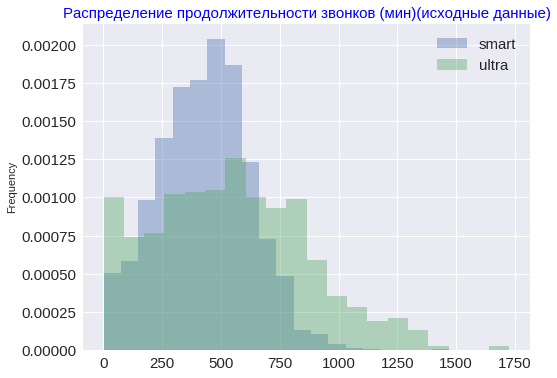

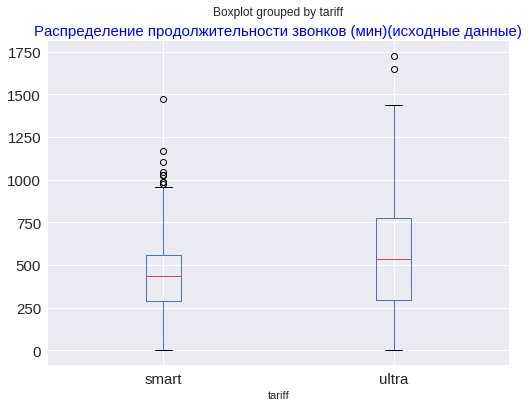

In [33]:
# Исходные данные
hist_graph(df, 'calls_duration', 'Распределение продолжительности звонков (мин)(исходные данные)')
boxplotter(df,'calls_duration', 'Распределение продолжительности звонков (мин)(исходные данные)' )

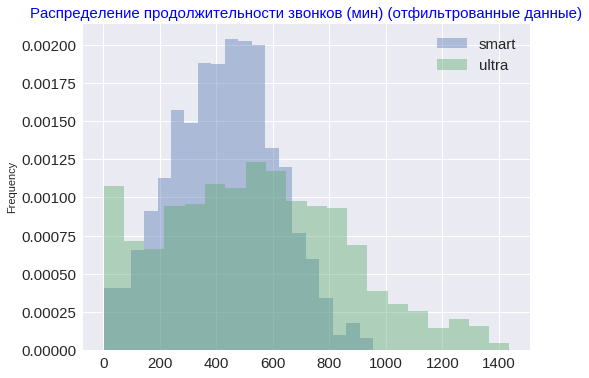

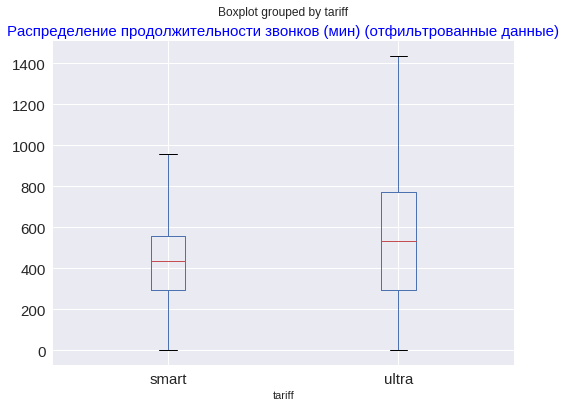

In [34]:
# Отфильтрованные
hist_graph(df_flt, 'calls_duration','Распределение продолжительности звонков (мин) (отфильтрованные данные)')
boxplotter(df_flt,'calls_duration', 'Распределение продолжительности звонков (мин) (отфильтрованные данные)')

In [35]:
# Расчет медианы, среднего, стандартного отклонения, дисперсии 
(df_flt
 .pivot_table(index='tariff', values=['calls_duration'], 
              aggfunc=['median','mean','var','std'])
 .sort_values(by='tariff', ascending=True)
 .round()
)

,median,mean,var,std
,calls_duration,calls_duration,calls_duration,calls_duration
tariff,,,,
smart,434.0,429.0,34734.0,186.0
ultra,532.0,540.0,102609.0,320.0


#### Вывод
* Пользователям тарифа "СМАРТ" обычно требуется **434** минут (медиана)    
* Пользователям тарифа "УЛЬТРА"обычно требуется **532** минуты (медиана)  
* Для распределений наблюдается скошенность вправо, для тарифа "УЛЬТРА" более ярко выраженная

#### Интернет


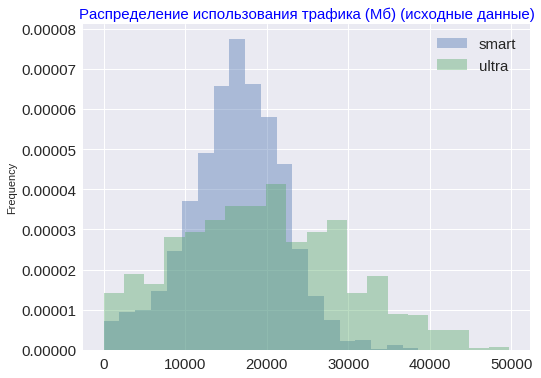

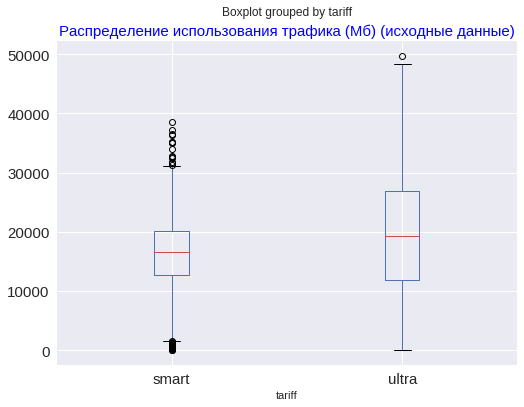

In [36]:
# Исходные данные
hist_graph(df,'mb_used', 'Распределение использования трафика (Мб) (исходные данные)')
boxplotter(df,'mb_used', 'Распределение использования трафика (Мб) (исходные данные)')

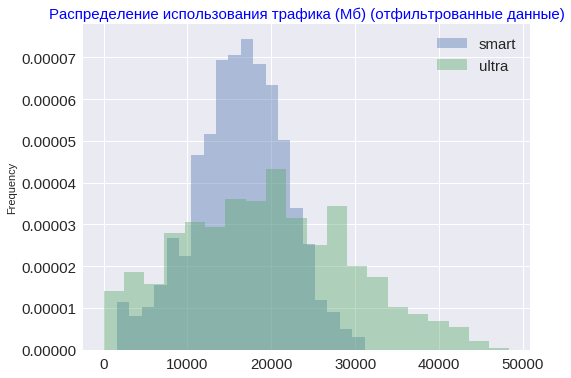

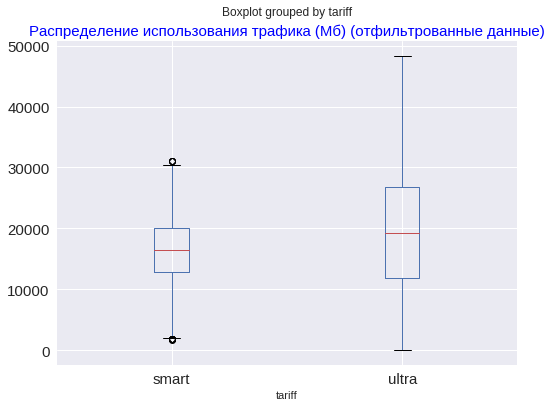

In [37]:
# Отфильтрованные
hist_graph(df_flt,'mb_used','Распределение использования трафика (Мб) (отфильтрованные данные)')
boxplotter(df_flt,'mb_used','Распределение использования трафика (Мб) (отфильтрованные данные)')

In [38]:
# Расчет медианы, среднего, стандартного отклонения, дисперсии 
(df_flt
 .pivot_table(index='tariff', values=['mb_used'], 
              aggfunc=['median','mean','var','std'])
 .sort_values(by='tariff', ascending=True)
 .round()
)

,median,mean,var,std
,mb_used,mb_used,mb_used,mb_used
tariff,,,,
smart,16514.0,16250.0,30397169.0,5513.0
ultra,19297.0,19417.0,100084600.0,10004.0


#### Вывод
* Пользователям тарифа "СМАРТ" обычно требуется **16** Гб (медиана)    
* Пользователям тарифа "УЛЬТРА"обычно требуется **19** Гб (медиана) 
* Распределений практически симметричны
-----


#### Сообщения

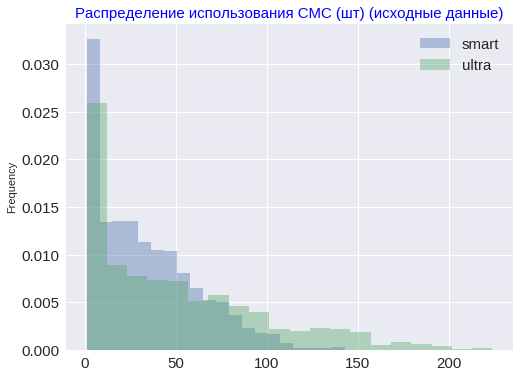

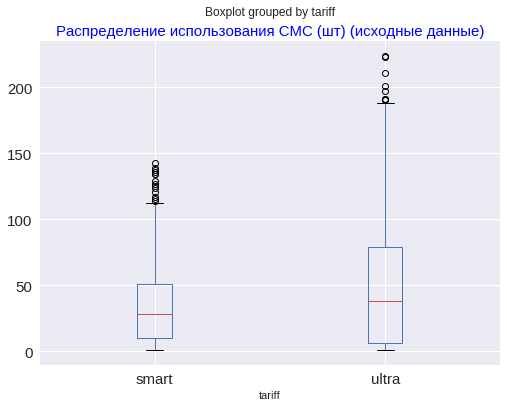

In [39]:
# Исходные данные
hist_graph(df,'message_count','Распределение использования СМС (шт) (исходные данные)')
boxplotter(df,'message_count','Распределение использования СМС (шт) (исходные данные)')

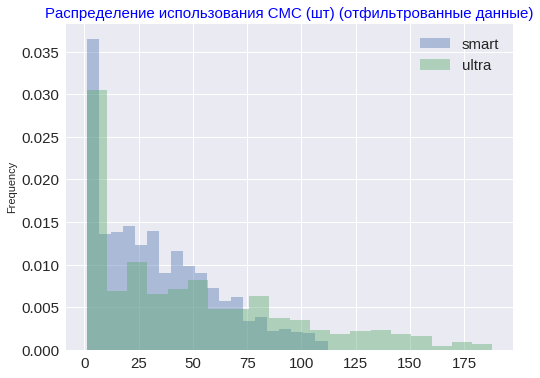

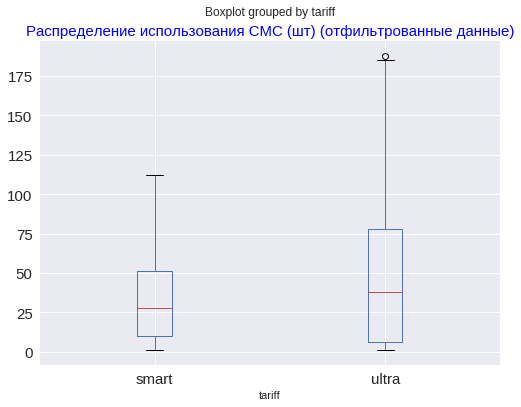

In [40]:
# Отфильтрованные
hist_graph(df_flt,'message_count','Распределение использования СМС (шт) (отфильтрованные данные)')
boxplotter(df_flt,'message_count','Распределение использования СМС (шт) (отфильтрованные данные)')

In [41]:
# Расчет медианы, среднего, стандартного отклонения, дисперсии 
(df_flt
 .pivot_table(index='tariff', values=['message_count'], 
              aggfunc=['median','mean','var','std'])
 .sort_values(by='tariff', ascending=True)
 .round()
)

,median,mean,var,std
,message_count,message_count,message_count,message_count
tariff,,,,
smart,28,33.0,732.0,27.0
ultra,38,48.0,2088.0,46.0


#### Вывод
* Пользователям тарифа "СМАРТ" обычно требуется **28** сообщений (медиана)    
* Пользователям тарифа "УЛЬТРА"обычно требуется **38** сообщений (медиана) 
* Для распределений наблюдается сильная скошенность вправо, для тарифа "УЛЬТРА" более ярко выраженная

**Наблюдаемые распределения для звонков и интернета визуально близки к нормальным, но несимметричны, поэтому в оценке потребления лучше использовать медиану, для сообщений однозначно медиана, так как распределение даже близко не похоже на нормальное.**

###  Шаг 4.  гипотезы


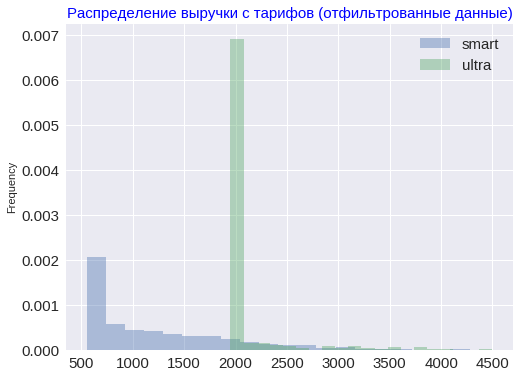

In [42]:
# Построим распределение выручки с тарифов
hist_graph(df_flt, 'total_fee', 'Распределение выручки с тарифов (отфильтрованные данные)')

#### Гипотезы о равенстве средних двух независимых совокупностей
* Будем проверять **средние выручки по тарифам** (они и есть наши независимые совокупности)
* обозначим их `АR`( от англ. `average revenue`)
------------
*Нулевая гипотеза Н0:*        **AR(смарт) = AR(ультра)** 

*Альтернативная гипотеза Н1:* **AR(смарт) != AR(ультра)**



In [43]:
# Функция для проверки p-value
    
def ttest_independent(df1, df2):
    alpha = 0.05
    results = st.ttest_ind(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)
smart_total_fee = df_smart['total_fee']
ultra_total_fee = df_ultra['total_fee']
ttest_independent(smart_total_fee, ultra_total_fee)

Отвергаем нулевую гипотезу, p-value: 1.0442721777445852e-254


In [44]:
# Рассчитаем средние выручки в тарифах
print('Средняя выручка в тарифе "СМАРТ":', smart_total_fee.mean().round(), 'рублей')
print('Средняя выручка в тарифе "УЛЬТРА":', ultra_total_fee.mean().round(), 'рублей')

Средняя выручка в тарифе "СМАРТ": 1166.0 рублей
Средняя выручка в тарифе "УЛЬТРА": 2046.0 рублей


##### Вывод: 
------------
**средняя выручка по тарифу "СМАРТ" почти в два меньше чем по тарифу "УЛЬТРА"**

------------
#### Проверим гипотезу о том, что средняя выручка абонентов из Москвы отличается от средней выручки абонентов других регинов
------------
*Нулевая гипотеза Н0:*        **AR(Москва) = AR(Другие регионы)** 

*Альтернативная гипотеза Н1:* **AR(Москва) != AR(Другие регионы)**


In [45]:
# Функция для категоризации регионов
def region_category(row):
    city = row['city']
    if city == 'Москва':
        return 'Москва'
    return 'Другой'
df_flt['region'] = df_flt.apply(region_category, axis=1)

In [46]:
# Создадим столбцы с выручкой для регионов
msk = df_flt.query('region=="Москва"')['total_fee']
others = df_flt.query('region=="Другой"')['total_fee']

In [47]:
# Проверяем  p-value
ttest_independent(msk, others)

Не получилось отвергнуть нулевую гипотезу,  p-value: 0.2310265932119201


In [48]:
# Посчитаем выручку в Москве и других регионах
print('Средняя выручка в Москве:', msk.mean().round(), 'рублей')
print('Средняя выручка в других регионах:', others.mean().round(), 'рублей')

Средняя выручка в Москве: 1470.0 рублей
Средняя выручка в других регионах: 1431.0 рублей


### ОБЩИЙ ВЫВОД:
>
Примечание: указаны медианные значения для минут, гигабайтов и  СМС сообщений 
>

-------------
**1) Минуты**
* Пользователям тарифа "СМАРТ" обычно требуется **434** минут     
* Пользователям тарифа "УЛЬТРА"обычно требуется **532** минуты 
------------
**2) Интернет**
* Пользователям тарифа "СМАРТ" обычно требуется **16** Гб     
* Пользователям тарифа "УЛЬТРА"обычно требуется **19** Гб  
-----------
**3) Сообщения**
* Пользователям тарифа "СМАРТ" обычно требуется **28** сообщений     
* Пользователям тарифа "УЛЬТРА"обычно требуется **38** сообщений 
----------
**4) Средняя выручка по тарифам**
* В тарифе "СМАРТ": **1166.0** рублей
* В тарифе "УЛЬТРА": **2046.0** рублей
* Отвергаем нулевую гипотезу **(p-value << alpha)**: p-value = 1.0442721777445852e-254
----------
**5) Средняя выручка по регионам**
* Средняя выручка в Москве: **1470.0** рублей
* Средняя выручка в других регионах: **1431.0** рублей
* Не получилось отвергнуть нулевую гипотезу,  **(p-value > alpha)**: p-value = 0.2310265932119201